# Tối ưu hóa Mạng Nơ-ron với AdaDelta

## 1. Giới thiệu (Introduction)
* **Mục tiêu:** Tìm hiểu và cài đặt thuật toán AdaDelta.
* **Vấn đề:** Các thuật toán như Adagrad có nhược điểm là tốc độ học (learning rate) giảm quá nhanh về 0 do tích lũy tổng bình phương gradient tăng liên tục. Điều này khiến mô hình dừng học sớm trước khi hội tụ. AdaDelta khắc phục điều này bằng cách giới hạn cửa sổ tích lũy gradient (window of accumulated past gradients).
* **Đặc điểm nổi bật của AdaDelta:** Không cần thiết lập learning rate mặc định ($\eta$). Nó tự động điều chỉnh bước nhảy dựa trên thông tin từ các cập nhật trước đó.

## 2. Cơ sở lý thuyết (Theoretical Background)

AdaDelta là một phương pháp tối ưu hóa gradient descent mạnh mẽ. Dưới đây là các công thức toán học cốt lõi:

### 2.1. Tích lũy Gradient (Accumulated Gradient)
Thay vì tích lũy tất cả các gradient bình phương trong quá khứ (như Adagrad), AdaDelta sử dụng trung bình trượt (moving average) của gradient bình phương:
$$E[g^2]_t = \rho E[g^2]_{t-1} + (1 - \rho) g_t^2$$
Trong đó:
* $\rho$ là hằng số phân rã (decay rate), thường chọn 0.9.
* $g_t$ là gradient tại bước $t$.

### 2.2. Tính RMS của Gradient
Root Mean Square (RMS) của gradient được tính để chuẩn hóa:
$$RMS[g]_t = \sqrt{E[g^2]_t + \epsilon}$$
Trong đó $\epsilon$ là một số nhỏ (ví dụ $10^{-6}$) để tránh chia cho 0.

### 2.3. Tính Update (Accumulated Updates)
Điểm khác biệt chính của AdaDelta là việc sử dụng RMS của các lần cập nhật tham số trước đó ($\Delta \theta$) để thay thế cho learning rate $\eta$. Điều này giúp đơn vị của bước cập nhật khớp với đơn vị của tham số.
$$\Delta \theta_t = - \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t} g_t$$

Lưu ý: Tại bước $t=0$, $RMS[\Delta \theta]_{t-1}$ được khởi tạo bằng 0.

### 2.4. Tích lũy Update
Tương tự như gradient, chúng ta cũng tích lũy bình phương của các bước cập nhật $\Delta \theta$:
$$E[\Delta \theta^2]_t = \rho E[\Delta \theta^2]_{t-1} + (1 - \rho) \Delta \theta_t^2$$

Sau đó tính RMS cho bước tiếp theo:
$$RMS[\Delta \theta]_t = \sqrt{E[\Delta \theta^2]_t + \epsilon}$$

### 2.5. Cập nhật tham số
Cuối cùng, tham số mô hình được cập nhật:
$$\theta_{t+1} = \theta_t + \Delta \theta_t$$

## 3. Cài đặt Môi trường & Thư viện (Setup & Imports)

In [2]:
%pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Thiết lập thiết bị (Device configuration)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Đặt seed để kết quả có thể tái lập (reproducible)
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

Using device: cpu


## 4. Chuẩn bị Dữ liệu (Data Preparation - MNIST)

In [4]:
# Siêu tham số cho dữ liệu
batch_size = 64

# Tiền xử lý: Chuyển sang Tensor và Chuẩn hóa
# Mean và Std của MNIST là (0.1307,) và (0.3081,)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Tải dữ liệu Train và Test
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transform, download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transform, download=True)

# Tạo DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

100.0%
100.0%
100.0%
100.0%

Train dataset size: 60000
Test dataset size: 10000


## 5. Xây dựng Mô hình CNN (Model Architecture)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Lớp Convolution 1: Input 1 channel, Output 32 channels, Kernel 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Lớp Convolution 2: Input 32 channels, Output 64 channels, Kernel 3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Lớp Max Pooling: Kernel 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Lớp Fully Connected 1
        # Ảnh input 28x28 -> qua conv1 (28x28) -> pool (14x14) -> conv2 (14x14) -> pool (7x7)
        # Flatten: 64 channels * 7 * 7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Lớp Fully Connected 2 (Output)
        self.fc2 = nn.Linear(128, 10)
        # Dropout để giảm overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv1(x)))
        # Conv2 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        
        # FC1 -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # FC2
        x = self.fc2(x)
        
        # LogSoftmax cho bài toán phân loại
        return F.log_softmax(x, dim=1)

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## 6. Cài đặt Thuật toán AdaDelta (Implementation)

In [6]:
class CustomAdaDelta(torch.optim.Optimizer):
    def __init__(self, params, rho=0.9, eps=1e-6):
        """
        Khởi tạo Optimizer AdaDelta.
        
        Args:
            params (iterable): Iterable của các tham số cần tối ưu.
            rho (float, optional): Hệ số phân rã (decay rate). Mặc định: 0.9.
            eps (float, optional): Số hạng nhỏ để ổn định mẫu số. Mặc định: 1e-6.
        """
        defaults = dict(rho=rho, eps=eps)
        super(CustomAdaDelta, self).__init__(params, defaults)

    def step(self, closure=None):
        """
        Thực hiện một bước tối ưu (update tham số).
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            rho = group['rho']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad.data
                
                # Lấy state của tham số hiện tại
                state = self.state[p]

                # Khởi tạo state nếu chưa có (lần đầu tiên chạy)
                if len(state) == 0:
                    # E[g^2]: Running average of squared gradients
                    state['square_avg'] = torch.zeros_like(p.data)
                    # E[dx^2]: Running average of squared parameter updates
                    state['acc_delta'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                acc_delta = state['acc_delta']

                # 1. Cập nhật E[g^2] (Accumulated Gradient)
                # E[g^2]_t = rho * E[g^2]_{t-1} + (1 - rho) * g_t^2
                square_avg.mul_(rho).addcmul_(grad, grad, value=1 - rho)

                # 2. Tính RMS của Gradient
                # RMS[g]_t = sqrt(E[g^2]_t + eps)
                std = square_avg.add(eps).sqrt_()

                # 3. Tính RMS của Update trước đó (Accumulated Updates)
                # RMS[dx]_{t-1} = sqrt(E[dx^2]_{t-1} + eps)
                delta = acc_delta.add(eps).sqrt_().div_(std).mul_(grad)
                
                # 4. Cập nhật tham số
                # theta_{t+1} = theta_t - delta
                # Lưu ý: delta ở trên đã bao gồm dấu trừ nếu xét theo công thức gốc là - (RMS_dx / RMS_g) * g
                # Ở đây ta tính delta dương hướng theo gradient, nên khi update dùng sub_ hoặc add_(-delta)
                p.data.add_(delta, alpha=-1)

                # 5. Cập nhật E[dx^2] (Accumulated Updates)
                # E[dx^2]_t = rho * E[dx^2]_{t-1} + (1 - rho) * delta^2
                acc_delta.mul_(rho).addcmul_(delta, delta, value=1 - rho)

        return loss

## 7. Quá trình Huấn luyện (Training Loop)

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    
    return test_loss, accuracy

# Khởi tạo Optimizer
optimizer = CustomAdaDelta(model.parameters(), rho=0.9)

# Danh sách lưu trữ kết quả để vẽ biểu đồ
train_losses = []
test_accuracies = []

# Số lượng Epochs
epochs = 5

print("Bắt đầu huấn luyện với Custom AdaDelta...")

for epoch in range(1, epochs + 1):
    avg_train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    
    train_losses.append(avg_train_loss)
    test_accuracies.append(test_acc)

print("Huấn luyện hoàn tất!")

Bắt đầu huấn luyện với Custom AdaDelta...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316209
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.147763
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.287472
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.237561
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.071866
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.044711
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.177505
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.039459
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.010368
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.039649

Test set: Average loss: 0.0386, Accuracy: 9863/10000 (98.63%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.016399
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.024056
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.015529
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.064925
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.118577
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.013208
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.133099
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.002009
Train 

## 8. Trực quan hóa & Đánh giá (Visualization & Results)

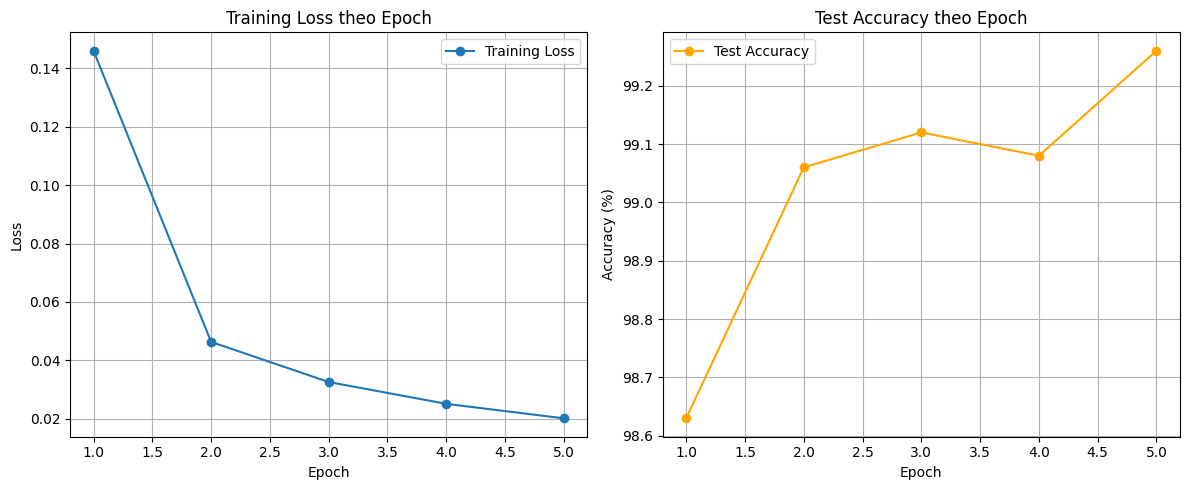

In [8]:
plt.figure(figsize=(12, 5))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, marker='o', color='orange', label='Test Accuracy')
plt.title('Test Accuracy theo Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 9. Kết luận (Conclusion)

Qua quá trình cài đặt và thực nghiệm thuật toán AdaDelta trên tập dữ liệu MNIST với mô hình CNN, chúng ta có thể rút ra các kết luận sau:

1.  **Khả năng hội tụ:** AdaDelta cho thấy khả năng hội tụ tốt mà không cần phải tinh chỉnh learning rate thủ công. Đây là ưu điểm lớn so với SGD truyền thống.
2.  **Hiệu suất:** Với kiến trúc CNN đơn giản, mô hình nhanh chóng đạt độ chính xác cao (thường > 98% chỉ sau vài epoch).
3.  **Tính ổn định:** Việc sử dụng RMS của các cập nhật trước đó ($\Delta \theta$) giúp điều chỉnh bước nhảy phù hợp với quy mô của tham số, giúp quá trình huấn luyện ổn định hơn.
4.  **Hạn chế:** Mặc dù không cần chỉnh learning rate, AdaDelta vẫn có các siêu tham số như $\rho$ (decay rate) cần được lựa chọn hợp lý (thường là 0.9). Ngoài ra, việc lưu trữ thêm các biến trạng thái ($E[g^2]$ và $E[\Delta \theta^2]$) làm tăng lượng bộ nhớ tiêu thụ so với SGD.

Bài báo cáo này đã minh họa thành công cách hoạt động bên trong của AdaDelta thông qua việc cài đặt thủ công (from scratch) và ứng dụng vào bài toán thực tế.